# Shopify Data Scientist Internship Challenge _ Shawn Gong

## Directory

1. [Question 1 Analysis](#q1analysis)

2. [Question 1 Answers](#q1answers)

3. [Question 2 Answers](#q2answers)


In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Question 1 - Sneaker Store Revenue Analysis <a name="q1analysis"></a>

Preliminary EDA and Data Quality Assessment

Objective: 
1. To get a rough idea about the dataset, the distribution of features and specific traits of the data that are potentially helpful for further analysis and insights extraction. 
2. To identify any outlier or any empty value and fix them before further analysis. 
3. Identify and fix data quality issues.

In [2]:
# Loading required data and display the head
df_sneaker = pd.read_csv('2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv')
df_sneaker.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [3]:
# The datatype of each column
df_sneaker.dtypes

order_id           int64
shop_id            int64
user_id            int64
order_amount       int64
total_items        int64
payment_method    object
created_at        object
dtype: object

Problem #1: The variables 'created_at' and 'payment_method' are not in their correct data type. The payment_method should be `category` while created_at should be `datetime`. We could also change the ids into object instead of treating them as numerical.

In [4]:
# Convert the variables to appropriate data types
df_sneaker_clean = (df_sneaker.astype({'order_id': 'object',
                                       'shop_id': 'object',
                                       'user_id': 'object',
                                       'payment_method': 'category',
                                       'created_at': 'datetime64'}))

In [5]:
# Is there any empty value?
print(df_sneaker[df_sneaker.isna()].count())

order_id          0
shop_id           0
user_id           0
order_amount      0
total_items       0
payment_method    0
created_at        0
dtype: int64


In [6]:
# Define a new function to explore the variables
def outlier_analysis(variables=None, data=df_sneaker_clean, log_scale=False, variable_limit=5):
    '''
    A function to explore a variable from the data source defined by argument'data'. The functi
    on will plot a histogram and a box plot for each of the variable specified in argument 'var
    -iable' or all the variables in the dataframe specified by argument 'data'.It will also pri
    nt the number of outliers in each variable outside the interquartile range (IQR):
    
    I = [Q_1 - 1.5 * IQR, Q_3 + 1.5 * IQR]
    
    * IQR is defined as the difference between the third quartile (75% percentile) and the firs
    t quartile (25% percentile).
    
    Args:
    variables: A list of strings. The variables to analyze, the function will output analysis f
    or all the variables up to the variable_limit number of variables if this argument is set t
    o None. Default: None. 
    data: pd.DataFrame. The dataframe input. Default: df_sneaker_clean.
    log_scale: Boolean. Whether to transform the histogram with log scale. Default: False.
    variable_limit: Integer. The upper limit for the number of variables displayed. Default: 5
    
    Returns:
    None
    '''
    
    # Define the figure size for histogram and boxplot
    if variables == None:
        variables = list(data.select_dtypes([np.number]).columns) # Column names of numerical columns in the dataframe
    limit = min(len(variables), variable_limit)
    fig = plt.figure(figsize=(20, 10))
    axes = fig.subplots(limit, 2, squeeze=False)
    # Iterate over the list of variable names to plot and print the outlier statistics
    for i, var in enumerate(variables):
        # Histogram
        axes[i, 0].hist(var, bins=30, data=data, log=log_scale)
        axes[i, 0].set_title('The histogram of {}'.format(var))
        axes[i, 0].set_xlabel(var)
        if log_scale:
            axes[i, 0].set_ylabel('log(frequency)')
        # Box plot
        axes[i, 1].boxplot(var, data=data)
        axes[i, 1].set_title('The boxplot of {}'.format(var))
        axes[i, 1].set_xlabel(var)
        # Number of outliers
        q1 = data[var].quantile(0.25)
        q3 = data[var].quantile(0.75)
        iqr = q3 - q1
        lower_limit = q1 - 1.5 * iqr
        upper_limit = q3 + 1.5 * iqr
        print("The number of outliers in {} is: {}".format(var, (1-data[var].between(lower_limit, upper_limit)).sum()))
        if i == limit-1:
            break
        

The number of outliers in order_amount is: 141
The number of outliers in total_items is: 18


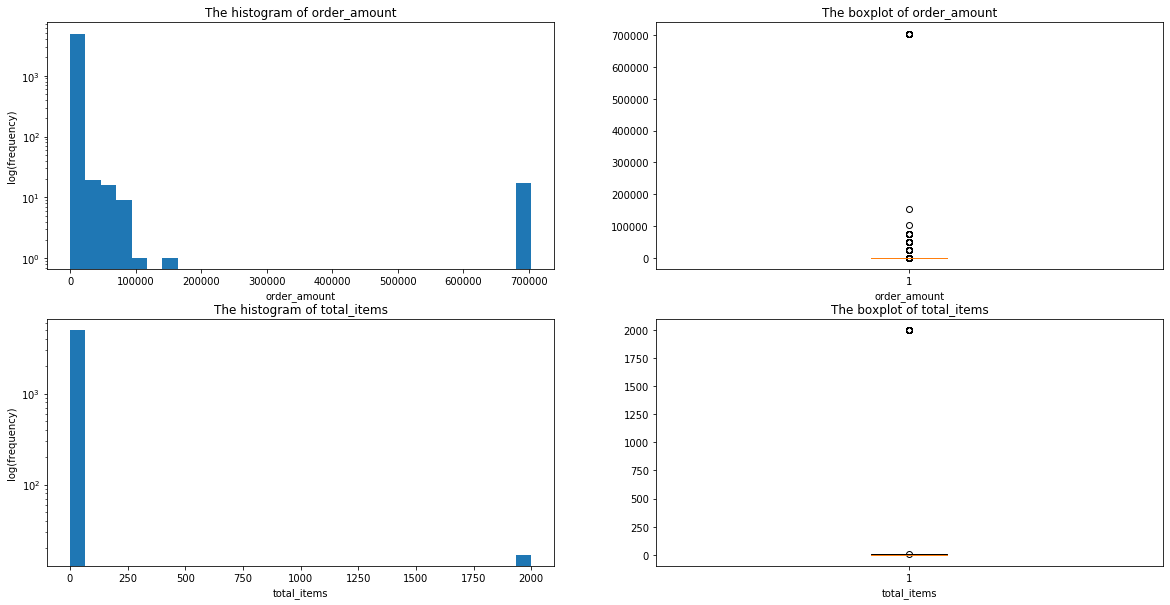

In [7]:
outlier_analysis(log_scale=True)

From the above plot, there are around 20 orders in the 30 day window that have order amounts at around 700000, which seriously distorted the mean value, resulting in the unrealistic AOV value of 3145 per order.

Additionally, another interesting finding is that the distribution of `order_amount` is not synchronized with that of `total_items`. The majority of `total_items` lies within 200, and there are 18 outliers in total. However, the `order_amount` has observed 123 more outliers than the the `order_amount`. If we assume the shop only sold sneakers in the "affordable" price range, the distribution of the two variables should be more closely synchronized with each other. By creating a new variable `unit_price`, we should be able to understand the reason for this behaviour.

In [8]:
# New variable "unit_price"
df_sneaker_clean['unit_price'] = df_sneaker_clean['order_amount'] / df_sneaker_clean['total_items']

The number of outliers in unit_price is: 97


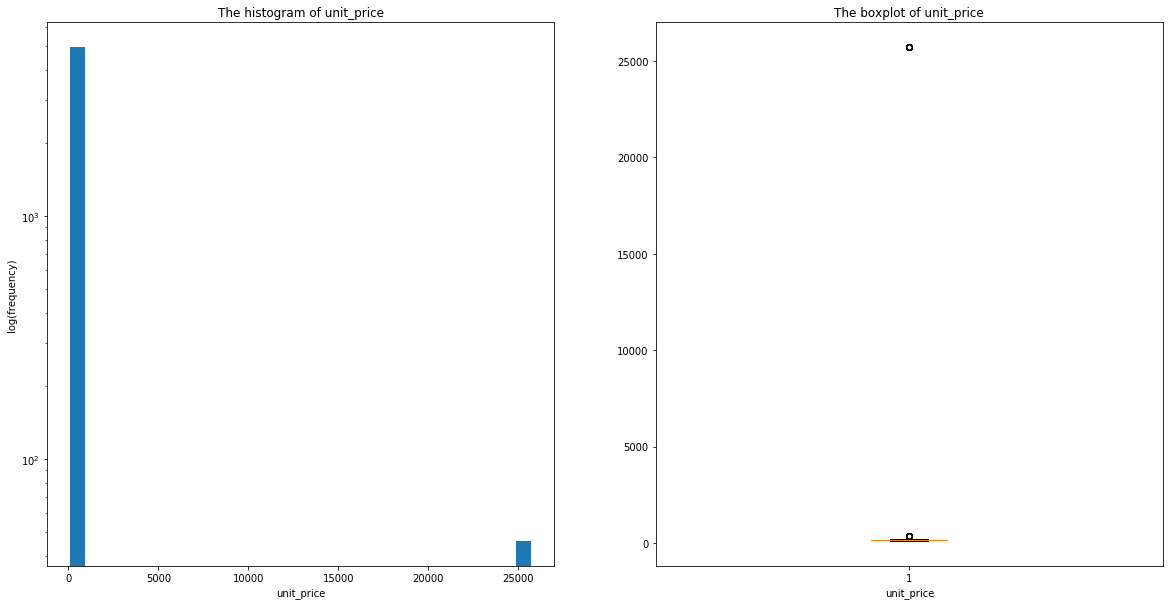

In [9]:
outlier_analysis(variables = ['unit_price'], log_scale=True)

In [10]:
# What are the orders that have outlying unit_price
q1_up = df_sneaker_clean['unit_price'].quantile(0.25)
q3_up = df_sneaker_clean['unit_price'].quantile(0.75)
iqr_up = q3_up - q1_up
lower_limit_up = q1_up - 1.5 * iqr_up
upper_limit_up = q3_up + 1.5 * iqr_up
df_sneakers_price_anomaly = df_sneaker_clean[(1 - df_sneaker_clean['unit_price'].between(lower_limit_up, upper_limit_up)).astype('bool')]

In [11]:
# The number of orders
df_sneakers_price_anomaly.groupby('unit_price').size()

unit_price
352.0      51
25725.0    46
dtype: int64

In [12]:
# The shop that sold the ultra expensive sneaker
price_anomaly_shop_id = df_sneakers_price_anomaly[df_sneakers_price_anomaly['unit_price'] == 25725].shop_id.unique()
print("The shop(s) that sold $25725 sneaker is(are): shop number {}".format(price_anomaly_shop_id))

The shop(s) that sold $25725 sneaker is(are): shop number [78]


There are 97 total outliers in the unit price variable, among which there is 46 orders with a whopping \$25725 unit price, which is extremely unlikely for regular sneakers in shops. In further investigation, all these shoes with extraordinary unit price are sold in one store only. There are two possibilities regarding this anomaly:
1. Store 78 has encountered system error and the order values they recorded in the period observed in the dataset are not correctly recorded due to some system error or human errors.
2. Store 78 is a store that specializes in selling ultra high value sneakers.
3. The price of store 78 is listed in a foreign currency and has not been converted to dollars.

However, considering the frequency of these transaction (46 orders within 30 days), it is highly unlikely that the price anomaly being the result from the second circumstance. It is advised to further investigate the reason for this anomaly from the store's end.

In [13]:
# Distribution of each column
df_sneaker_clean.describe()

,order_amount,total_items,unit_price
count,5000.000000,5000.00000,5000.000000
mean,3145.128000,8.78720,387.742800
std,41282.539349,116.32032,2441.963725
min,90.000000,1.00000,90.000000
25%,163.000000,1.00000,133.000000
50%,284.000000,2.00000,153.000000
75%,390.000000,3.00000,169.000000
max,704000.000000,2000.00000,25725.000000


## Answer to Question 1 <a name="q1answers"></a>

- What metric would you report for this dataset and what's its value?

    According to the summary statistics, there are clearly some outliers that distorted the distribution. The largest order amount is several orders of magnitude larger than the orders in the normal range. This is the reason why mean is not an appropriate metric for evaluating average order value (AOV), as **mean is not resistant to outliers** and presents a misleading view on the overall performance of the store sales revenue. Instead, the store should use median as the evaluation metrics, which is outlier resistant and could reflect the general characteristics of the orders. Under the new metrics, the AOV of the `order_amount` is $284.

## Question 2 - SQL queries <a name="q2answers"></a>

**1. How many orders were shipped by Speedy Express in total?**

SQL Query:
```mysql
SELECT Shippers.ShipperName, COUNT(*) AS total_orders
FROM Orders
LEFT JOIN Shippers
ON Orders.ShipperID = Shippers.ShipperID
WHERE Shippers.ShipperName == "Speedy Express";
```

Result:

| ShipperName    | total_orders | 
|---|---|
| Speedy Express | 54           |

Speedy Express has shipped 54 orders in total.

**2. What is the last name of the employee with the most orders?**
SQL Query:
```mysql
SELECT Employees.LastName, COUNT(*) as total_orders
FROM Orders
LEFT JOIN Employees
ON Orders.EmployeeID = Employees.EmployeeID
GROUP BY Employees.employeeid
ORDER BY total_orders DESC
LIMIT 1;
```

Result:

| LastName    | total_orders | 
|---|---|
| Peacock | 40           |

The employee with last name "Peacock" has shipped the most orders, standing at 40 orders in total.

**3. What product was ordered the most by customers in Germany?**
SQL Query:
```mysql
SELECT Products.ProductName, SUM(Orderdetails.Quantity) as total_quantity, Customers.Country
FROM Orderdetails
LEFT JOIN Orders
ON Orderdetails.OrderID = Orders.OrderID
LEFT JOIN Products
ON Orderdetails.ProductID = Products.ProductID
LEFT JOIN Customers
ON Orders.CustomerID = Customers.CustomerID
WHERE Customers.Country = 'Germany'
GROUP BY Products.ProductName
ORDER BY total_quantity DESC
LIMIT 1;
```

Results:

| ProductName      | total_quantity | Country |
|------------------|----------------|---------|
| Boston Crab Meat | 160            | Germany |

The product that was ordered most by customers in Germany is Boston Crab Meat and the total quantity is 160.
